In [674]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pylab import rcParams
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

# data

In [675]:
data_owid = pd.read_csv("./dataset/owid-energy-data.csv")

In [676]:
data_owid

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.87,1.550,NaN,569.557,NaN,NaN,NaN,NaN,NaN,76.03,NaN,NaN,NaN,NaN,20.081,NaN,378.61,NaN,378.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.36,NaN,NaN,80.653,NaN,NaN,NaN,NaN,NaN,164.26,NaN,NaN,NaN,NaN,NaN,43.385,NaN,215.64,NaN,NaN,NaN,NaN,50.45,NaN,13.325,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,65.07,NaN,NaN,NaN,NaN,NaN,17.187,NaN,NaN,22.80,16.93,NaN,NaN,NaN,NaN,NaN,6.022,4.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.46,1.596,NaN,567.642,NaN,NaN,NaN,NaN,NaN,86.26,NaN,NaN,NaN,NaN,21.307,NaN,404.85,NaN,404.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.66,NaN,NaN,80.934,NaN,NaN,NaN,NaN,NaN,190.41,NaN,NaN,NaN,NaN,NaN,47.032,NaN,229.81,NaN,NaN,NaN,NaN,54.33,NaN,13.420,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,50.99,NaN,NaN,NaN,NaN,NaN,12.595,NaN,NaN,22.86,16.40,NaN,NaN,NaN,NaN,NaN,5.647,4.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN

## historical data for EDA

In [677]:
historical_data = data_owid.loc[(data_owid['year'] > 1930) & (data_owid['year'] < 2015) & (data_owid['country'] == 'Italy')]

In [678]:
historical_data

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9980,Italy,1931,ITA,40501139.0,1.866570e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.549,-0.479,69.411,2.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,0.093,4.594,0.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,Italy,1932,ITA,40843255.0,1.906655e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.543,0.184,73.333,2.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.750,0.128,7.688,0.314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,Italy,1933,ITA,41185511.0,1.884730e+11,N

In [679]:
data = pd.read_csv("./dataset/energy.csv") # produzione lorda e consumo di energia elettrica in Italia - Anni 1883-2014 (milioni di kWh)

In [680]:
data

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses
0,1931,"10,470","8,335",103,"6,213",803,209,"1,007",0
1,1932,"10,590","8,420",103,"6,223",845,225,"1,024",0
2,1933,"11,650","9,293",114,"6,984",860,243,"1,092",0
3,1934,"12,600","10,159",110,"7,684",879,258,"1,228",0
4,1935,"13,800","11,168",138,"8,583","1,003",267,"1,177",0
...,...,...,...,...,...,...,...,...,...
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551"
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140"
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457"
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983"


In [681]:
historical_data = historical_data.reset_index(drop=True)

In [682]:
data = data.reset_index(drop=True)

In [683]:
data['population'] = historical_data['population']

In [684]:
data['gdp'] = historical_data['gdp']

In [685]:
data.tail()

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551",59822452.0,2.080546e+12
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140",60025952.0,2.110883e+12
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457",60190152.0,2.047960e+12
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983",60312600.0,2.010255e+12
83,2014,"279,829","291,084","5,372","122,505","10,462","5,885","82,604","64,255",60322792.0,2.010164e+12


In [686]:
data['gdp_pp'] = data['gdp'] / data['population']

In [687]:
data['population'] = data['population'] / 1000

In [688]:
data['gdp'] = data['gdp'] / 10000000

In [689]:
for col in data.columns:
    if data[col].dtype == 'O':  
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [690]:
data

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp,gdp_pp
0,1931,10470,8335,103,6213,803,209,1007,0,40501.139,18665.701376,4608.685542
1,1932,10590,8420,103,6223,845,225,1024,0,40843.255,19066.545766,4668.223864
2,1933,11650,9293,114,6984,860,243,1092,0,41185.511,18847.304909,4576.197903
3,1934,12600,10159,110,7684,879,258,1228,0,41530.635,18798.734541,4526.474142
4,1935,13800,11168,138,8583,1003,267,1177,0,41878.651,19814.342656,4731.370802
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2010,302062,309885,5610,138439,10666,6366,79253,69551,59822.452,208054.596403,34778.680821
80,2011,302570,313792,5907,140040,10720,6202,80783,70140,60025.952,211088.336486,35166.178870
81,2012,299275,307220,5923,130801,10759,6261,84019,69457,60190.152,204795.989197,34024.833364
82,2013,289803,297288,5677,124871,10774,5977,83005,66983,60312.600,201025.532723,33330.603012


In [691]:
data['year'] = pd.to_datetime(data['year'],format='%Y')

In [692]:
data.set_index('year',inplace=True)

In [693]:
data

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp,gdp_pp
year,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,40501.139,18665.701376,4608.685542
1932-01-01,10590,8420,103,6223,845,225,1024,0,40843.255,19066.545766,4668.223864
1933-01-01,11650,9293,114,6984,860,243,1092,0,41185.511,18847.304909,4576.197903
1934-01-01,12600,10159,110,7684,879,258,1228,0,41530.635,18798.734541,4526.474142
1935-01-01,13800,11168,138,8583,1003,267,1177,0,41878.651,19814.342656,4731.370802
...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,302062,309885,5610,138439,10666,6366,79253,69551,59822.452,208054.596403,34778.680821
2011-01-01,302570,313792,5907,140040,10720,6202,80783,70140,60025.952,211088.336486,35166.178870
2012-01-01,299275,307220,5923,130801,10759,6261,84019,69457,60190.152,204795.989197,34024.833364


<Axes: xlabel='year'>

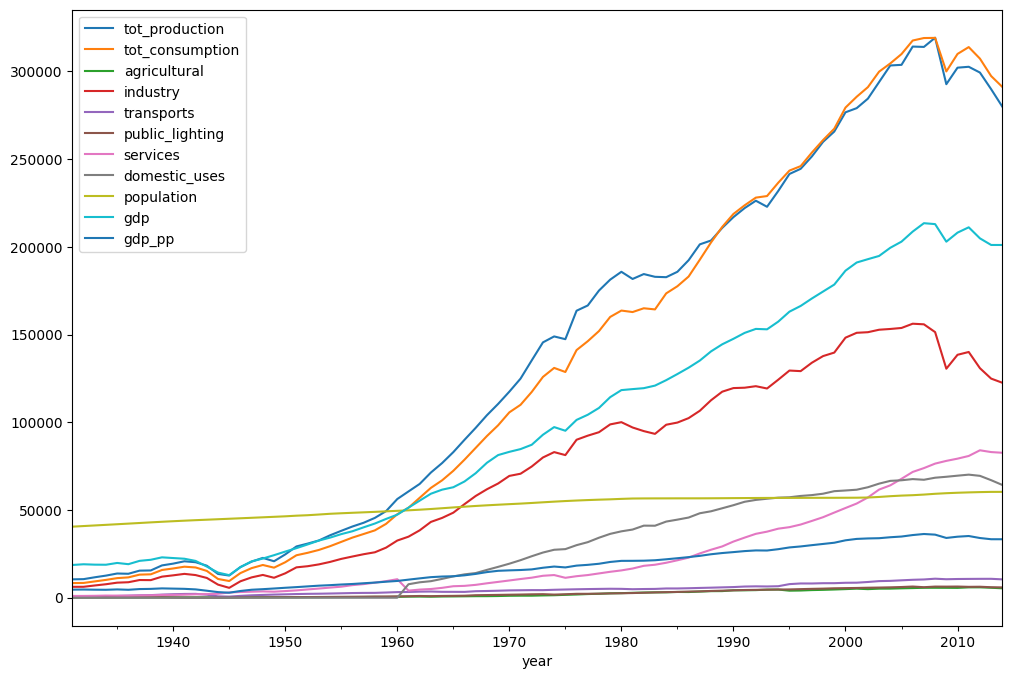

In [694]:
data.plot(figsize=(12,8))

<Axes: xlabel='year'>

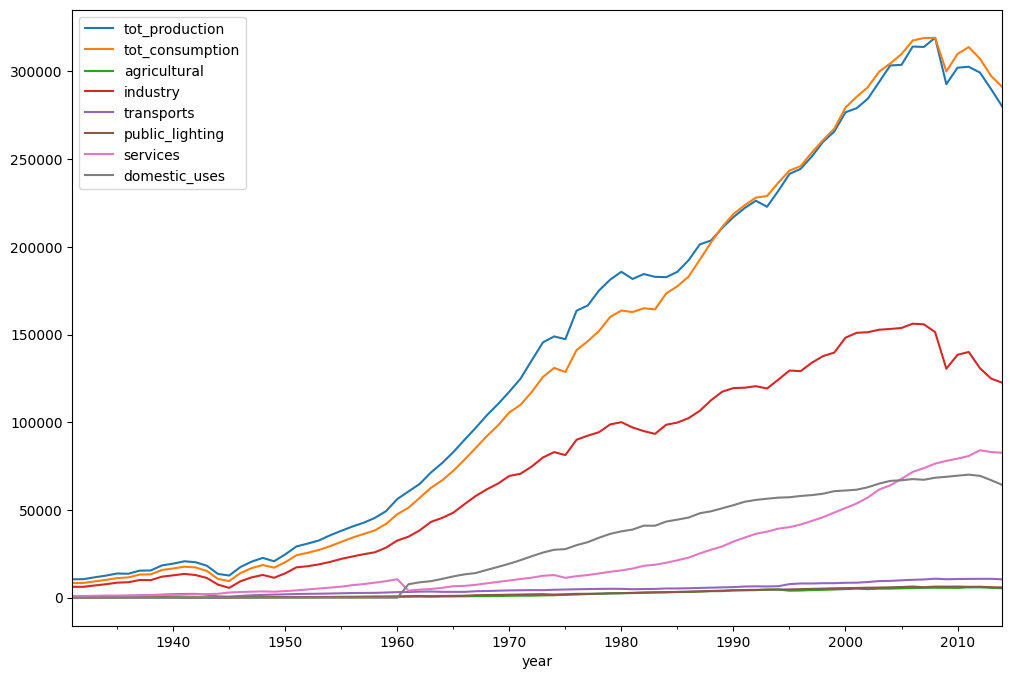

In [695]:
data.drop(['gdp','population','gdp_pp'],axis=1).plot(figsize=(12,8))

<Axes: xlabel='year'>

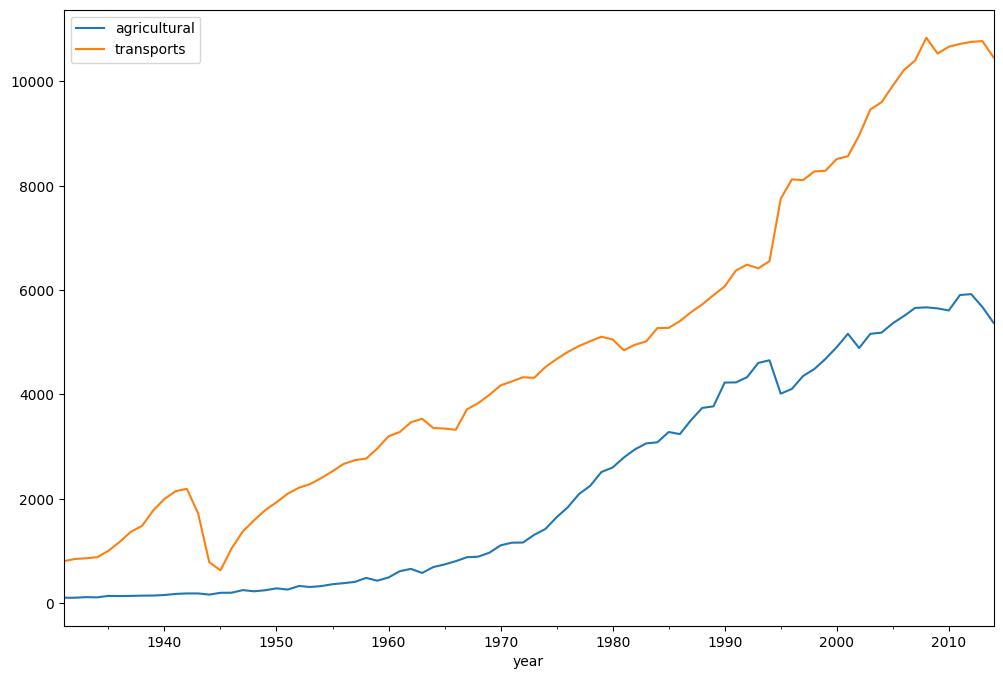

In [696]:
data[['agricultural','transports']].plot(figsize=(12,8))

In [697]:
prod_cycle,prod_trend = hpfilter(data['tot_production'])

<Axes: xlabel='year'>

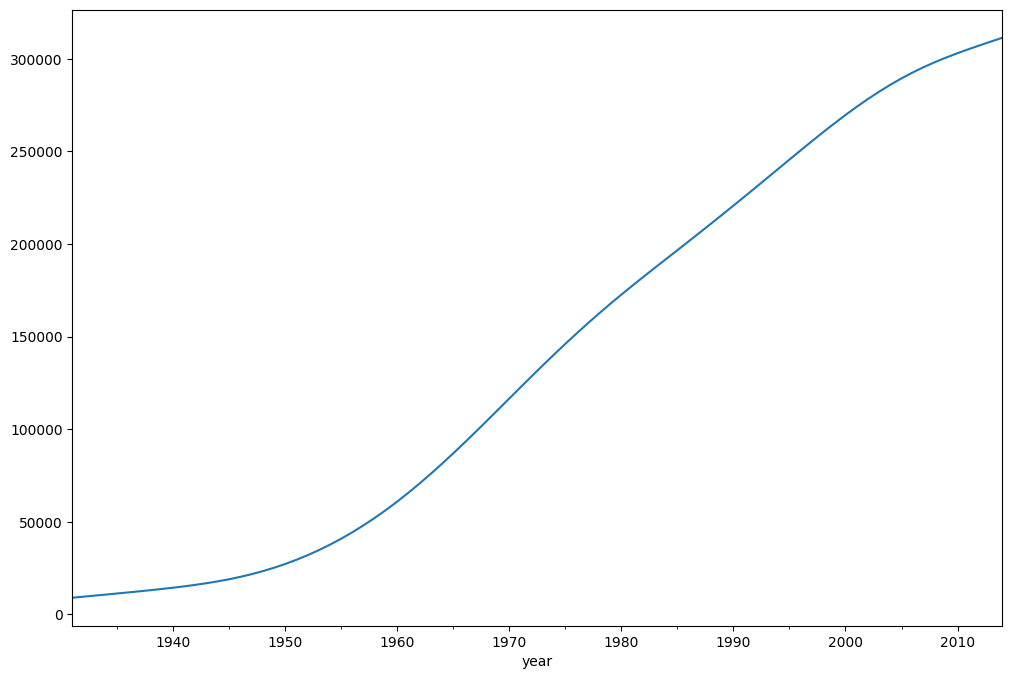

In [698]:
prod_trend.plot(figsize=(12,8))

In [699]:
data['production_trend'] = prod_trend

<Axes: xlabel='year'>

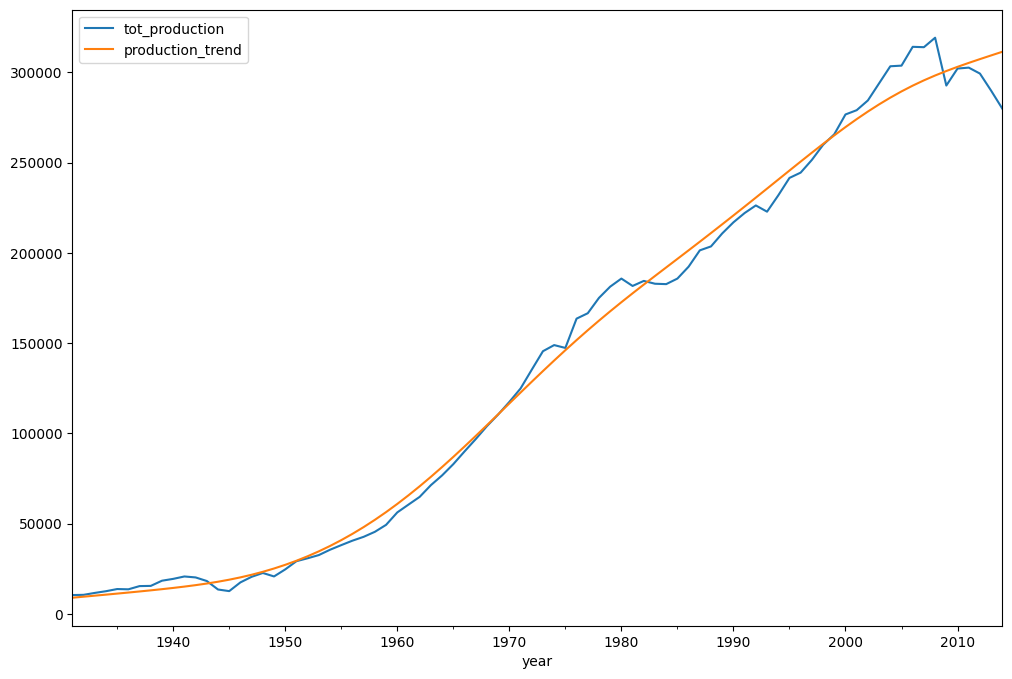

In [700]:
data[['tot_production','production_trend']].plot(figsize=(12,8))

In [701]:
cons_cycle,cons_trend = hpfilter(data['tot_consumption'])

In [702]:
data['consumption_trend'] = cons_trend

<Axes: xlabel='year'>

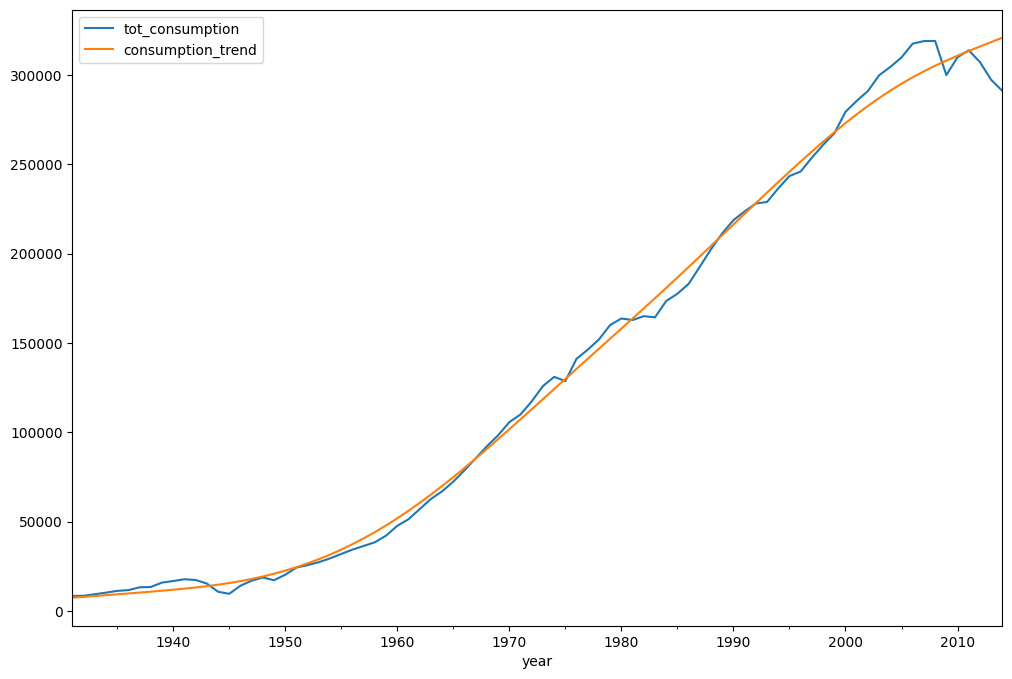

In [703]:
data[['tot_consumption','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

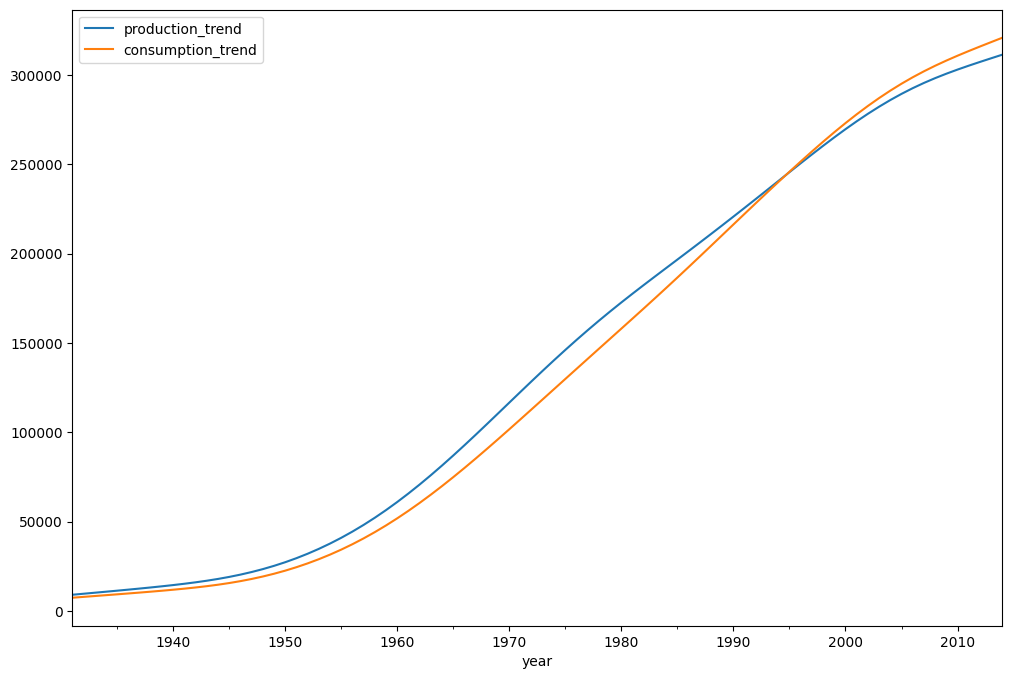

In [704]:
data[['production_trend','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

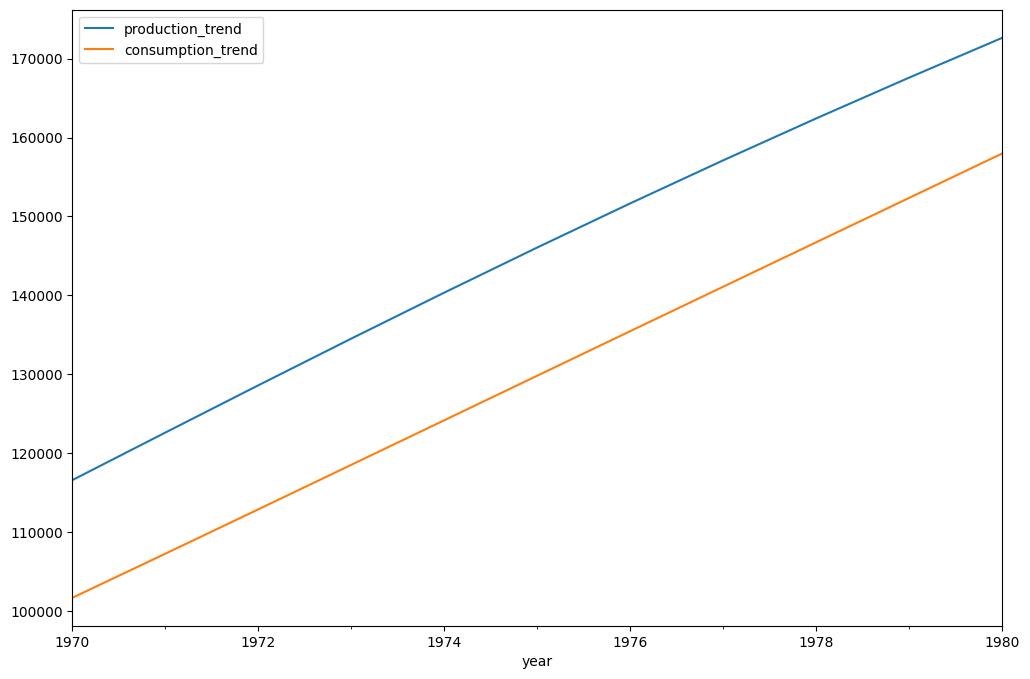

In [705]:
data[['production_trend','consumption_trend']].loc['1970-01-01':'1980-01-01'].plot(figsize=(12,8))

In [706]:
data['5-year-MA'] = data['tot_production'].rolling(window=5).mean()

In [707]:
data['10-year-MA'] = data['tot_production'].rolling(window=10).mean()

<Axes: xlabel='year'>

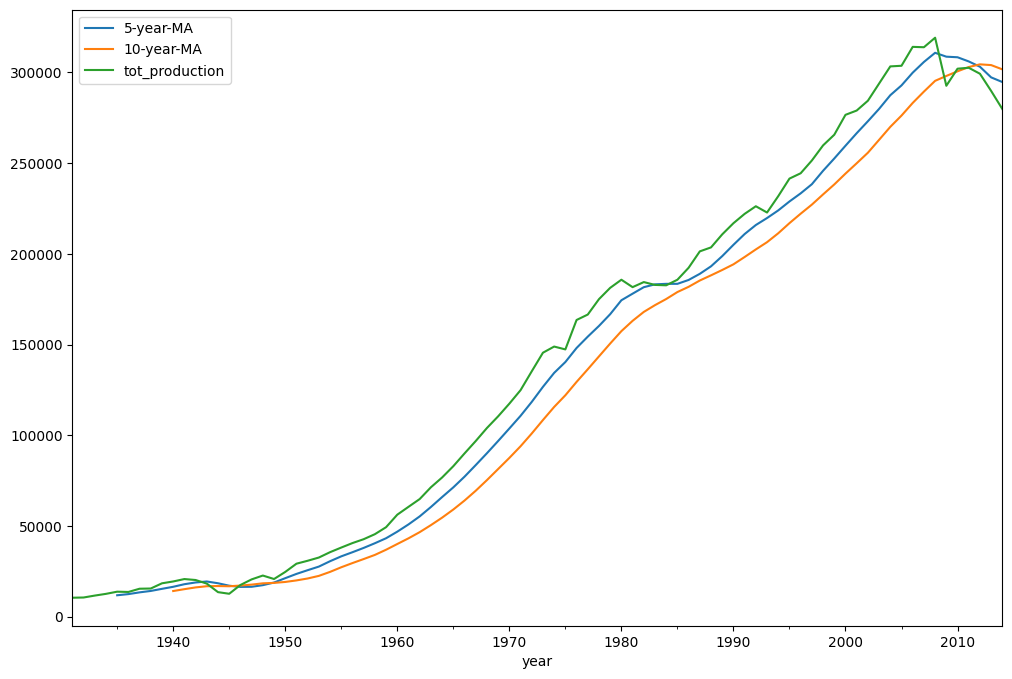

In [708]:
data[['5-year-MA','10-year-MA','tot_production']].plot(figsize=(12,8))

In [709]:
data.drop(['production_trend', 'consumption_trend','5-year-MA', '10-year-MA'],axis=1,inplace=True)

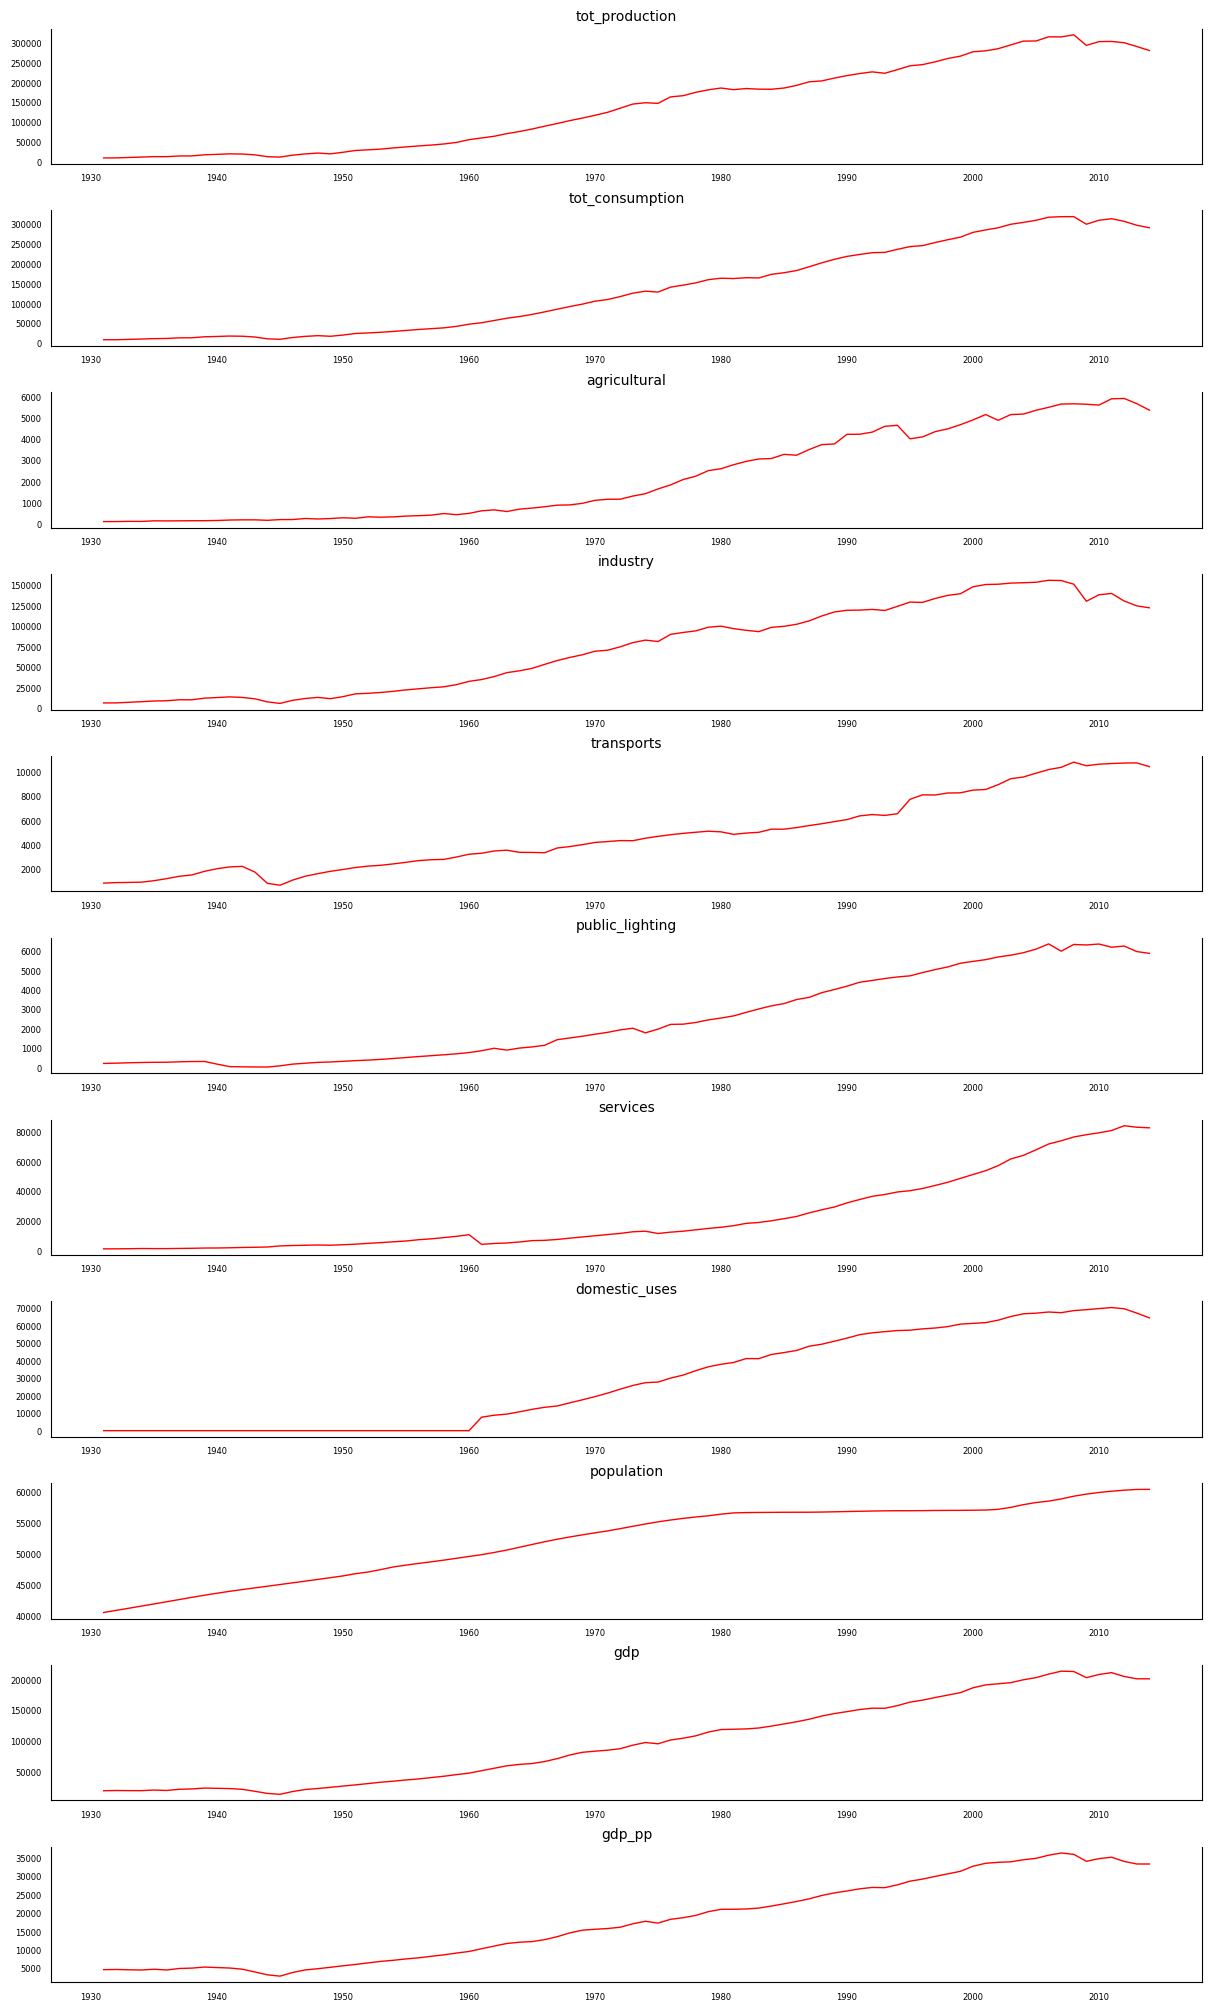

In [710]:
fig, axes = plt.subplots(nrows=11,figsize=(12, 20),constrained_layout=True)

for i, ax in enumerate(axes):
    data_ = data[data.columns[i]]
    
    ax.plot(data_, color='red', linewidth=1)
    ax.set_title(data.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

In [711]:
result = seasonal_decompose(data['tot_production'])

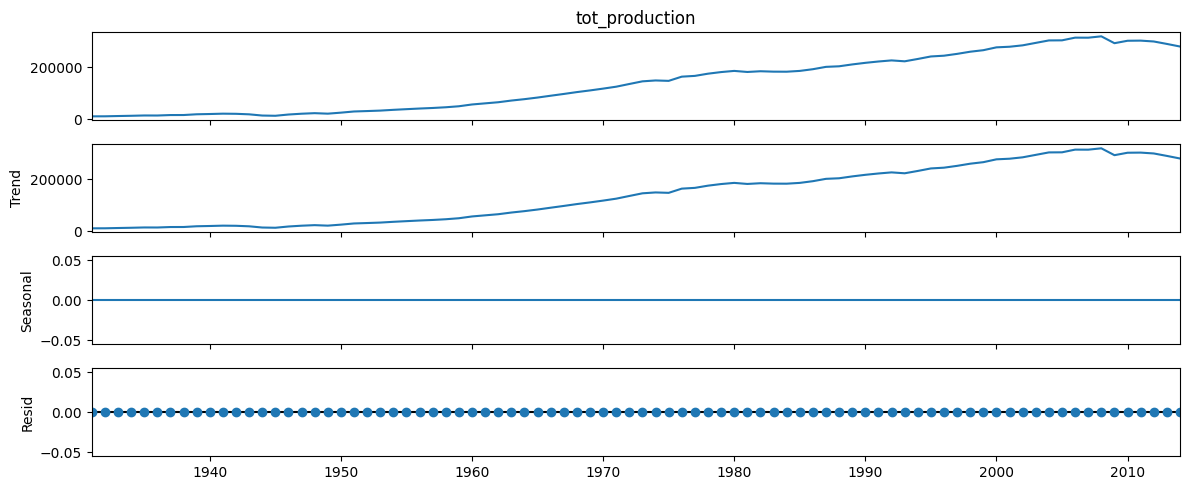

In [712]:
rcParams['figure.figsize'] = 12,5
result.plot();

In [713]:
result = seasonal_decompose(data['tot_consumption'])

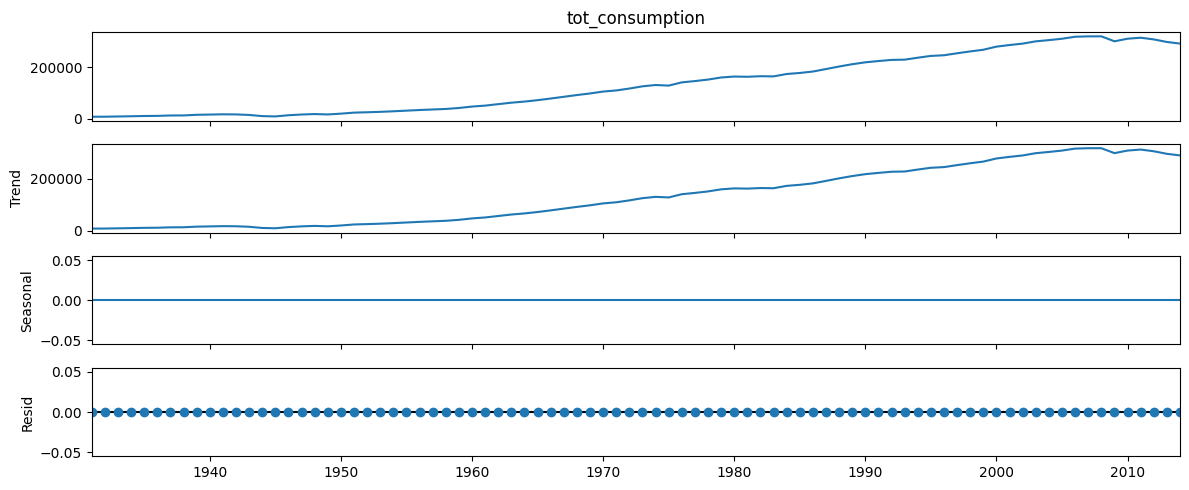

In [714]:
rcParams['figure.figsize'] = 12,5
result.plot();

## data for VAR model

In [715]:
cpi = pd.read_csv('./dataset/consumer-price-index.csv')

In [716]:
cpi

,Entity,Code,Year,Consumer price index (2010 = 100)
0,Italy,ITA,1960,4.147836
1,Italy,ITA,1961,4.232895
2,Italy,ITA,1962,4.431467
3,Italy,ITA,1963,4.761820
4,Italy,ITA,1964,5.043354
...,...,...,...,...
59,Italy,ITA,2019,110.623600
60,Italy,ITA,2020,110.471260
61,Italy,ITA,2021,112.541250
62,Italy,ITA,2022,121.771090


In [717]:
cpi = cpi[['Year','Consumer price index (2010 = 100)']].reset_index(drop=True)

In [718]:
cpi['Year'] = pd.to_datetime(cpi['Year'],format='%Y')

In [719]:
cpi = cpi.rename(columns={'Consumer price index (2010 = 100)':'cpi','Year':'year'})

In [720]:
cpi

,year,cpi
0,1960-01-01,4.147836
1,1961-01-01,4.232895
2,1962-01-01,4.431467
3,1963-01-01,4.761820
4,1964-01-01,5.043354
...,...,...
59,2019-01-01,110.623600
60,2020-01-01,110.471260
61,2021-01-01,112.541250
62,2022-01-01,121.771090


In [721]:
data_owid_italy = data_owid[data_owid['country'] == 'Italy'].copy()

In [722]:
data_owid_italy

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9949,Italy,1900,ITA,33332371.0,1.099054e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.112,1.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9950,Italy,1901,ITA,33571430.0,1.123700e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.250,-0.132,30.940,1.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.693,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9951,Italy,1902,ITA,33827207.0,1.151736e+11,NaN,NaN,NaN,Na

In [723]:
data_owid_italy['year'] = pd.to_datetime(data_owid_italy['year'],format='%Y')

In [724]:
exclude_cols = ['electricity_demand','electricity_generation','net_elec_imports','carbon_intensity_elec','per_capita_electricity','electricity_demand_per_capita',
                'electricity_share_energy','net_elec_imports_share_demand']

cols = [col for col in data_owid_italy.columns if 'electricity' in col and col not in exclude_cols]

data_owid_electricity = pd.concat(
    [data_owid_italy[['year','population','gdp'] + exclude_cols],data_owid_italy[cols]],axis=1).set_index('year').dropna()

In [725]:
data_owid_share_elec = pd.concat(
     [data_owid_italy[['year','electricity_demand','electricity_generation']],
     data_owid_italy.filter(like='share_elec',axis=1)],axis=1).set_index('year').dropna()

In [726]:
data_owid_electricity = data_owid_electricity.merge(cpi[['year','cpi']],left_index=True,right_index=True,how='left')

In [727]:
data_owid_electricity.head() # electricity generation from xxx measured in terawatt-hours

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,year,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,NaT,NaN
1991-01-01 00:00:00,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,NaT,NaN
1992-01-01 00:00:00,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,NaT,NaN
1993-01-01 00:00:00,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,NaT,NaN
1994-01-01 00:00:00,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,NaT,NaN


In [728]:
data_owid_electricity.head()

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,year,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,NaT,NaN
1991-01-01 00:00:00,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,NaT,NaN
1992-01-01 00:00:00,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,NaT,NaN
1993-01-01 00:00:00,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,NaT,NaN
1994-01-01 00:00:00,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,NaT,NaN


In [729]:
data_owid_share_elec.head() # share of electricity generated by xxx measured as a percentage of total electricity

,electricity_demand,electricity_generation,biofuel_share_elec,coal_share_elec,fossil_share_elec,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec
year,,,,,,,,,,,,,,,
1990-01-01,247.80,213.15,0.023,15.036,83.627,18.630,14.839,16.373,0.0,49.960,1.534,1.511,16.373,0.000,0.000
1991-01-01,253.51,218.43,0.050,13.048,79.156,16.637,19.338,20.844,0.0,49.471,1.506,1.456,20.844,0.000,0.000
1992-01-01,257.98,222.68,0.045,9.592,79.446,15.933,18.951,20.554,0.0,53.920,1.599,1.554,20.554,0.004,0.000
1993-01-01,259.17,219.74,0.055,7.582,79.421,18.185,18.850,20.579,0.0,53.654,1.725,1.670,20.579,0.005,0.000
1994-01-01,266.35,228.75,0.066,8.682,78.907,17.836,19.523,21.093,0.0,52.389,1.561,1.495,21.093,0.004,0.004


<Axes: xlabel='year'>

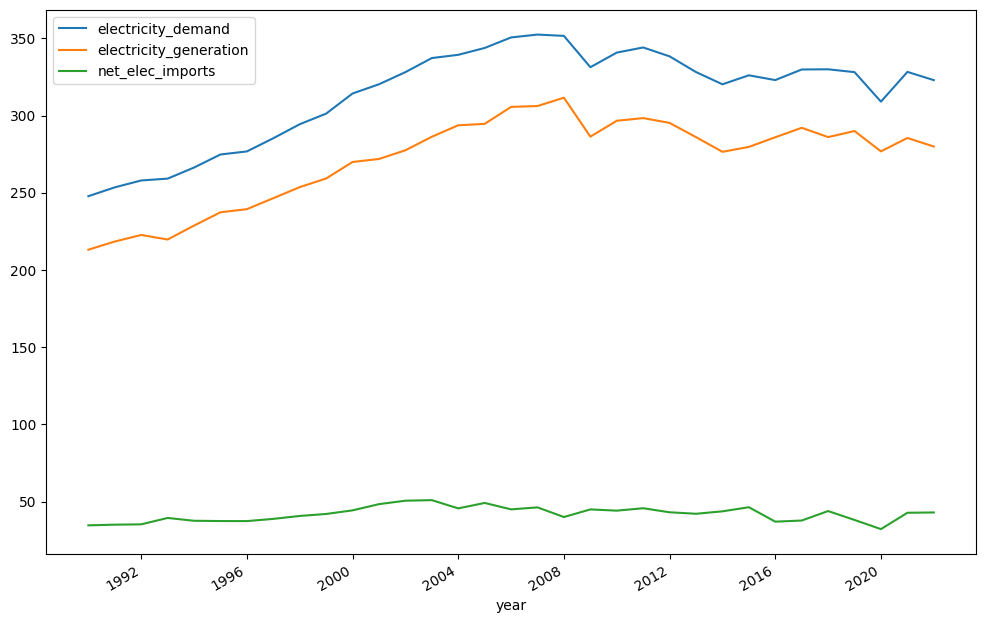

In [730]:
data_owid_electricity[['electricity_demand','electricity_generation','net_elec_imports']].plot(figsize=(12,8))

<Axes: xlabel='year'>

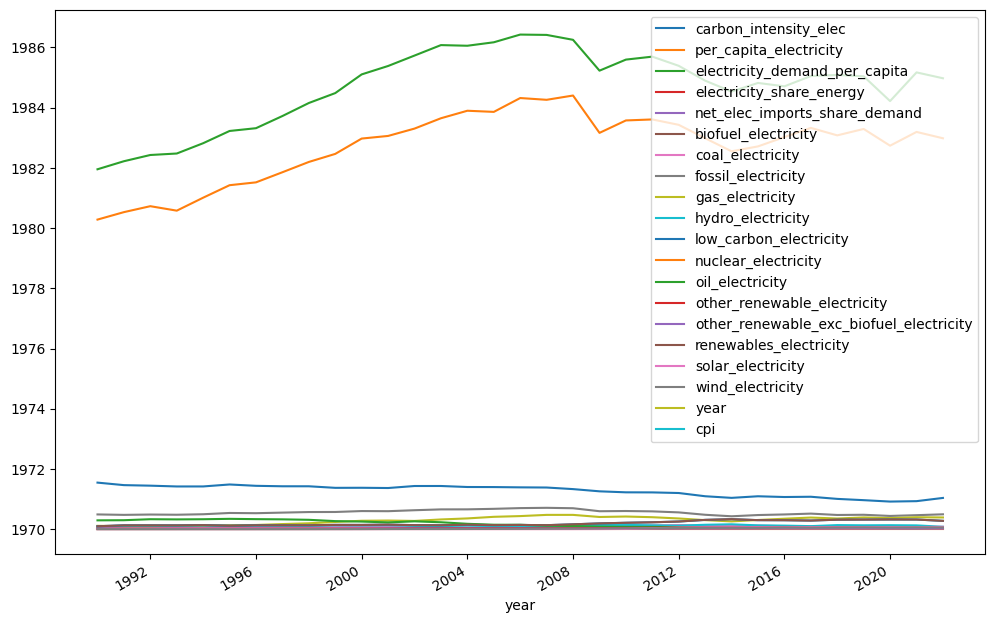

In [731]:
data_owid_electricity.drop(['population','gdp','electricity_demand','electricity_generation','net_elec_imports'],axis=1).plot(figsize=(12,8))

<Axes: xlabel='year'>

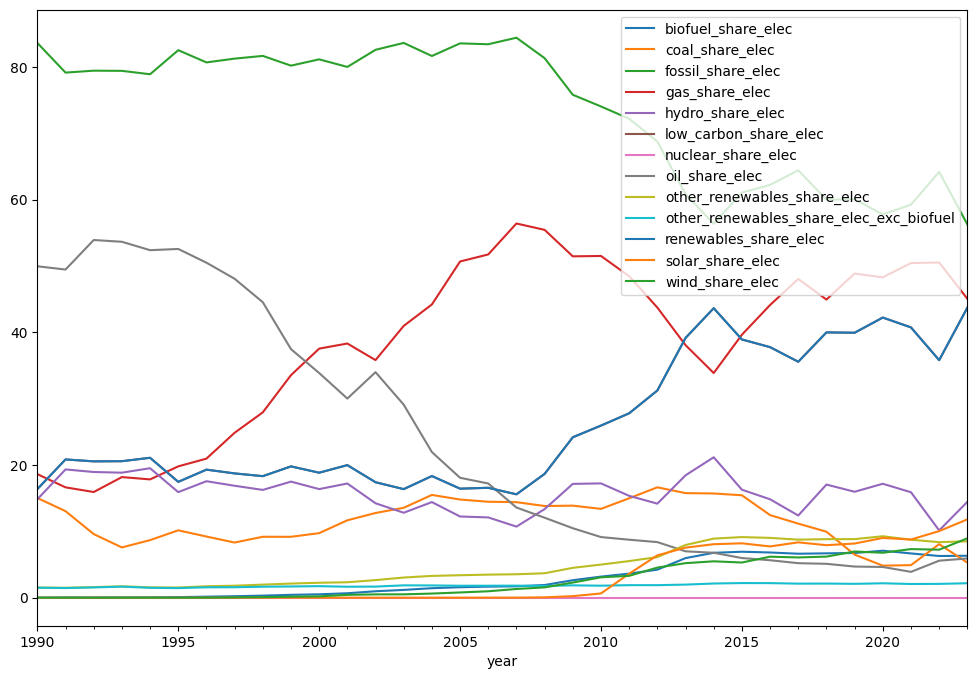

In [732]:
data_owid_share_elec.drop(['electricity_demand','electricity_generation'],axis=1).plot(figsize=(12,8))

In [733]:
data_owid_electricity.columns

Index(['population', 'gdp', 'electricity_demand', 'electricity_generation',
       'net_elec_imports', 'carbon_intensity_elec', 'per_capita_electricity',
       'electricity_demand_per_capita', 'electricity_share_energy',
       'net_elec_imports_share_demand', 'biofuel_electricity',
       'coal_electricity', 'fossil_electricity', 'gas_electricity',
       'hydro_electricity', 'low_carbon_electricity', 'nuclear_electricity',
       'oil_electricity', 'other_renewable_electricity',
       'other_renewable_exc_biofuel_electricity', 'renewables_electricity',
       'solar_electricity', 'wind_electricity', 'year', 'cpi'],
      dtype='object')

In [734]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['gdp'] / data_owid_electricity['population']

In [735]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['per_capita_gdp'] / 100

<Axes: xlabel='year'>

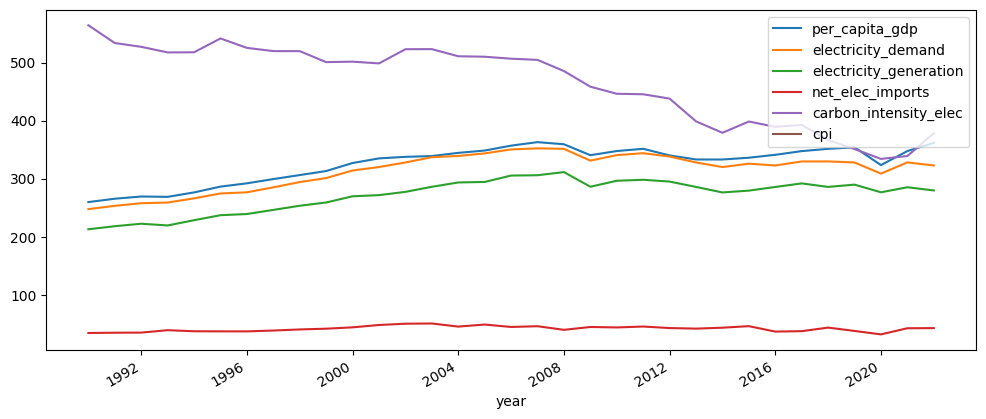

In [739]:
data_owid_electricity[['per_capita_gdp','electricity_demand','electricity_generation','net_elec_imports','carbon_intensity_elec','cpi']].plot()

# var model